In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

dataset = pd.read_csv('https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')

# Nos quedamos sólo con las que comienzan con pf_indentity, junto con otras columnas más generales
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

# Casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con -. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.
dataset = dataset[important_cols].replace('-', np.nan)
for score_col in score_cols:
    dataset[score_col] = pd.to_numeric(dataset[score_col])
dataset

# Por ahora las filas con NaN de hf_score y pf_identity las eliminaremos.
dataset = dataset.dropna(subset=['hf_score', 'pf_identity'])

dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


# Parte 1

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  

### 1.1 Rango de las variables

In [3]:
# 1.1 Rango de las variables

ranges = pd.concat([dataset.min(), dataset.max()], axis=1) 
ranges.columns = ['Minimo', 'Maximo']
print("Rangos de las variables: \n", ranges)

Rangos de las variables: 
                                          Minimo          Maximo
year                                       2008            2017
ISO_code                                    AGO             ZWE
countries                               Albania        Zimbabwe
region                  Caucasus & Central Asia  Western Europe
pf_identity_legal                             0              10
pf_identity_sex_male                          0              10
pf_identity_sex_female                        0              10
pf_identity_sex                               0              10
pf_identity_divorce                           0              10
pf_identity                                   0              10
pf_score                                   2.22            9.56
pf_rank                                       1             162
ef_score                                   2.58            9.11
ef_rank                                       1             162
hf_score     

### 1.2 Para este punto, podemos tomar a Argentina y Armenia para comparar los valores pf_identity y hf_score. Procedemos a calcular el promedio de la mitad de las agregaciones por pais.

La manera adecuada de comparar un país con otro va a depender de la pregunta que queramos responder.
Si quisiéramos ver una evolución temporal se podría hacer una regresión lineal  a través del tiempo, y la pendiente nos daría información de si crece o decrece el parámetro.
Si se quisiera comparar el estado en un momento específico se puede hacer un análisis transversal, considerando una realización para cada país u otra opción es considerando un rango temporal, por ejemplo los últimos 5 años, y comparar el promedio entre esos datos.

In [65]:
# 1.2 Comparación de hf_score y pf_identity de Argentina con Armenia.

# Procedemos a calcular el dataset argentino para las dos variables y tomaremos solo su mitad para compararlo con Armenia
argentina_dataset = dataset.loc[dataset['countries']=='Argentina',['year','pf_identity','hf_score']]
argentina_dataset.sort_values(by=['year']) # Ordenamos por columna año
argentina_dataset_to_compare = argentina_dataset.head(int(len(argentina_dataset)/2)) # Dividimos el tamaño del dataset argentino en 2
display(argentina_dataset_to_compare)

# Procedemos a calcular el dataset de Armenia para las dos variables y tomaremos solo su mitad para compararlo con Argentina
armenia_dataset = dataset.loc[dataset['countries']=='Armenia',['year','pf_identity','hf_score']]
armenia_dataset.sort_values(by=['year']) # Ordenamos por columna año
armenia_dataset_to_compare = armenia_dataset.head(int(len(armenia_dataset)/2)) # Dividimos el tamaño del dataset de Armenia en 2
display(armenia_dataset_to_compare)

hf_score_argentina_mean = argentina_dataset_to_compare['hf_score'].mean()
hf_score_armenia_mean = armenia_dataset_to_compare['hf_score'].mean()

pf_identity_argentina_mean = argentina_dataset_to_compare['pf_identity'].mean()
pf_identity_armeina_mean = armenia_dataset_to_compare['pf_identity'].mean()

print('\n')
print("Media de hf_score de Argentina: %f, hf_score de Armenia: %f" %(hf_score_argentina_mean, hf_score_armenia_mean))
print("Media de pf_identity de Argentina: %f, pf_identity de Armenia: %f" %(pf_identity_argentina_mean, pf_identity_armeina_mean))



,year,pf_identity,hf_score
3,2017,10.0,6.86
165,2016,10.0,6.75
327,2015,10.0,6.54
489,2014,10.0,6.27
651,2013,10.0,6.55


,year,pf_identity,hf_score
4,2017,8.2,7.42
166,2016,8.2,7.44
328,2015,8.2,7.34
490,2014,8.8,7.43
652,2013,8.8,7.53




Media de hf_score de Argentina: 6.594000, hf_score de Armenia: 7.432000
Media de pf_identity de Argentina: 10.000000, pf_identity de Armenia: 8.440000


Creemos que tomar los ultimos 5 años de mediciones por cada pais, nos puede dar un índice significativo de la situacion actual de libertad para cada variable por región. Consideramos que la media es la medicion correcta para este caso, ya que nos brinda  un especie de resumen para comparar los dos países. Los valores de ambas vairables al estar en el rango de 0 a 10, no se observan outliers, por lo que la mediana no sería necesiaria utilizarla, ya que si tuvieramos outliers la mediana nos aportaría información mas útil que la media. y la moda no creo que serían significativas para comparar las variables entre paises.

### 1.3 Media, mediana y desviación estandar para pf_identity y hf_score


In [5]:
# 1.3 Media, mediana y desviación estandar para pf_identity y hf_score

hf_score_mean_world = dataset['hf_score'].mean()
pf_identity_mean_world = dataset['pf_identity'].mean()

hf_score_median_world = dataset['hf_score'].median()
pf_identity_median_world = dataset['pf_identity'].median()

hf_score_std_world = dataset['hf_score'].std()
pf_identity_std_world = dataset['pf_identity'].std()

hf_score_mean_latinamerica_caribbean = dataset[(dataset.region == "Latin America & the Caribbean")]['hf_score'].mean()
pf_identity_mean_latinamerica_caribbean = dataset[(dataset.region == "Latin America & the Caribbean")]['pf_identity'].mean()

hf_score_median_latinamerica_caribbean = dataset[(dataset.region == "Latin America & the Caribbean")]['hf_score'].median()
pf_identity_median_latinamerica_caribbean = dataset[(dataset.region == "Latin America & the Caribbean")]['pf_identity'].median()


hf_score_std_latinamerica_caribbean = dataset[(dataset.region == "Latin America & the Caribbean")]['hf_score'].std()
pf_identity_std_latinamerica_caribbean = dataset[(dataset.region == "Latin America & the Caribbean")]['pf_identity'].std()

hf_score_table = pd.DataFrame({'Media': [hf_score_mean_world, hf_score_mean_latinamerica_caribbean],
                   'Mediana': [hf_score_median_world, hf_score_median_latinamerica_caribbean],
                   'Desviación Estandar': [hf_score_std_world, hf_score_std_latinamerica_caribbean]},
                  index=['Mundo', 'Latinoamerica'])

pf_identity_table = pd.DataFrame({'Media': [pf_identity_mean_world, pf_identity_mean_latinamerica_caribbean],
                   'Mediana': [pf_identity_median_world, pf_identity_median_latinamerica_caribbean],
                   'Desviación Estandar': [pf_identity_std_world, pf_identity_std_latinamerica_caribbean]},
                  index=['Mundo', 'Latinoamerica'])

print("Valores para hf_score:")
display(hf_score_table)
print('\n')
print("Valores para pf_identity:")
display(pf_identity_table)



Valores para hf_score:


,Media,Mediana,Desviación Estandar
Mundo,6.978214,6.90,1.056239
Latinoamerica,7.036977,7.02,0.634897




Valores para pf_identity:


,Media,Mediana,Desviación Estandar
Mundo,7.280649,8.8,3.181577
Latinoamerica,8.582171,10.0,1.875832


La comparación con respecto al mundo es válida para ver la comparación de latinoamerica con respecto al mundo. Creemos que el principal parametro a comparar es la media, como expresamos anteriormente. La desviación estandar nos da una visión de la dispersión de los datos a lo largo de los años.

### 1.4 Calcular la moda, tiene sentido?

Creemos que no tiene sentido calcular la moda ya que para esta situación la moda no nos aporta información útil. La moda nos brinda el dato que mas se repite, para este caso que estamos comparando la libertad humana (hf_score) y el promedio de las libertades personales (pf_identity), no nos sería importante ver los datos que más se repiten si no que necesitamos tratar de abarcar todos los datos y representarlos de alguna forma (a través de la media). En el caso de que nuestros datos de interés tengan outliers, ahí sería conveniente calcular la moda ya que en dicha situación nos aportaría información útil.


### 1.5 Sanear los valores faltantes

Para este análisis hemos removido las filas con valores NaN en las columnas hf_score y pf_identity, para facilitar nuestro trabajo. Pero se podría no eliminarlos y reemplazarlos por algún otro valor de interés como la media o la moda. Como en este caso los valores son númericos creo que la media sería mas convneniente de utilizar en vez de la moda. Si estos fueran categóricos la moda sería conveniente. 

### 1.6 Presencia de Outliers

El método utilizado para la detección de outliers fue la representación gráfica del rango intercuatil mediante la función boxplot de seaborn.
Se observó que la variable pf_identity no presenta outliers globares (considerando todo el mundo), pero si presenta outliers en algunas de sus regiones,
en cambio la variable hf_score presenta outliers en algunas regiones y en el análisis global.
Creemos que si sería necesario removerlos.


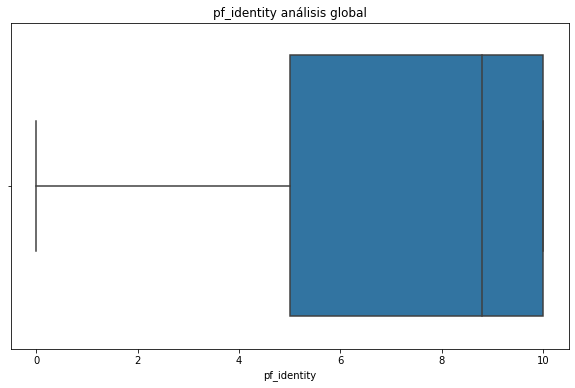

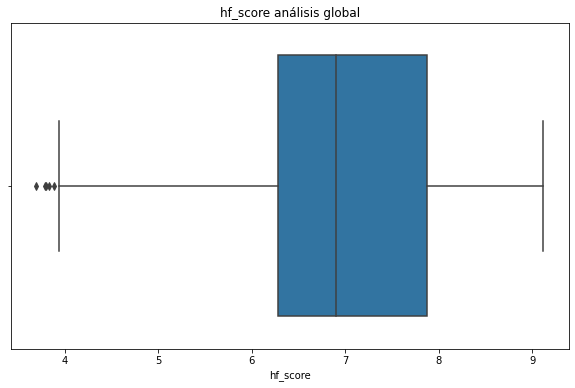

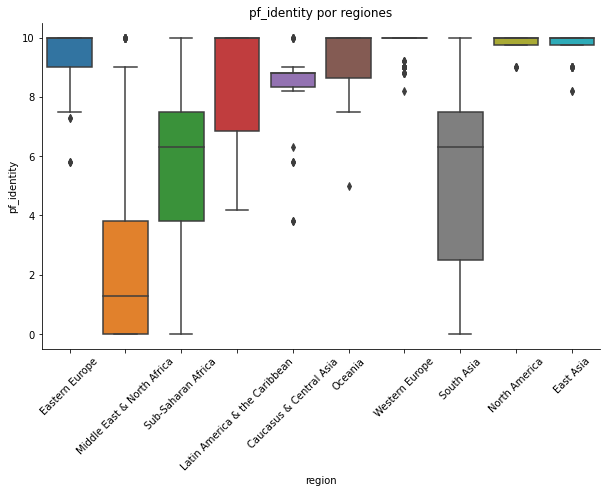

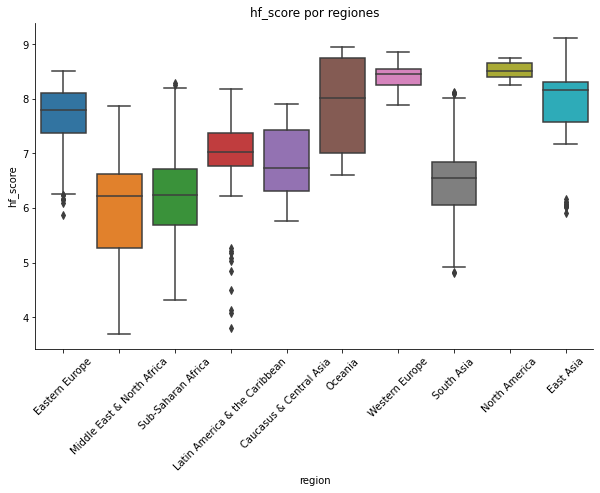

In [64]:
plt.figure(figsize=(10,6))
plt.title('pf_identity análisis global')
seaborn.boxplot(x=dataset['pf_identity'])
plt.figure(figsize=(10,6))
plt.title('hf_score análisis global')
seaborn.boxplot(x=dataset['hf_score'])
plt.figure(figsize=(10,6))
seaborn.boxplot(data=dataset,
                x='region', y='pf_identity')
plt.ylabel('pf_identity')
plt.xlabel('region')
plt.title('pf_identity por regiones')
plt.xticks(rotation=45)
seaborn.despine()
plt.figure(figsize=(10,6))
seaborn.boxplot(data=dataset,
                x='region', y='hf_score')
plt.ylabel('hf_score')
plt.xlabel('region')
plt.title('hf_score por regiones')
plt.xticks(rotation=45)
seaborn.despine()

## 2. Agregación de datos
1. Grafiquen la media de la variable pf_identity y hf_score a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable pf_identity en la región. ¿Cómo seleccionaron los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de hf_score y ef_score a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

### 2.1 Media, a través de los años, de hf_score y pf_identity

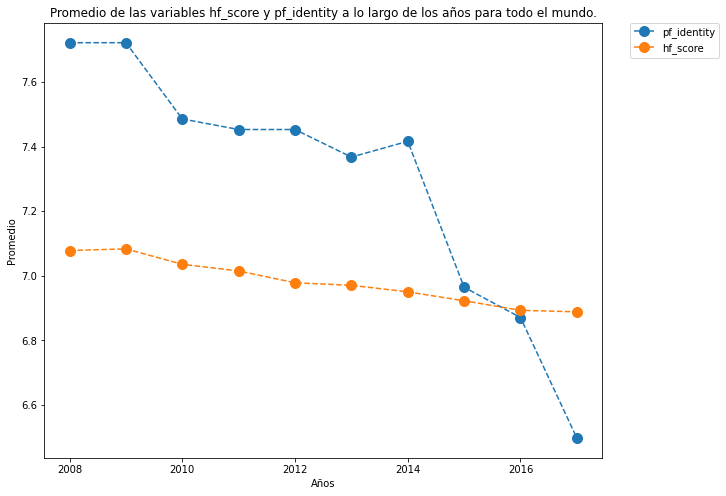

In [6]:
# Media, a través de los años, de hf_score y pf_identity

# Agrupamos las dos columnas por año.
dataset_group_by_year = dataset[['year','pf_identity', 'hf_score']].groupby('year').mean()
dataset_group_by_year = dataset_group_by_year.reset_index() # Ponemos al año como una columna

plt.figure(figsize=(10,8))
plt.plot(dataset_group_by_year['year'], dataset_group_by_year['pf_identity'], label='pf_identity',linestyle='--', marker='o', markersize=10)
plt.plot(dataset_group_by_year['year'], dataset_group_by_year['hf_score'], label='hf_score', linestyle='--', marker='o', markersize=10)

plt.ylabel('Promedio')
plt.xlabel('Años')
plt.title('Promedio de las variables hf_score y pf_identity a lo largo de los años para todo el mundo.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 2.2 Gráfico por región.

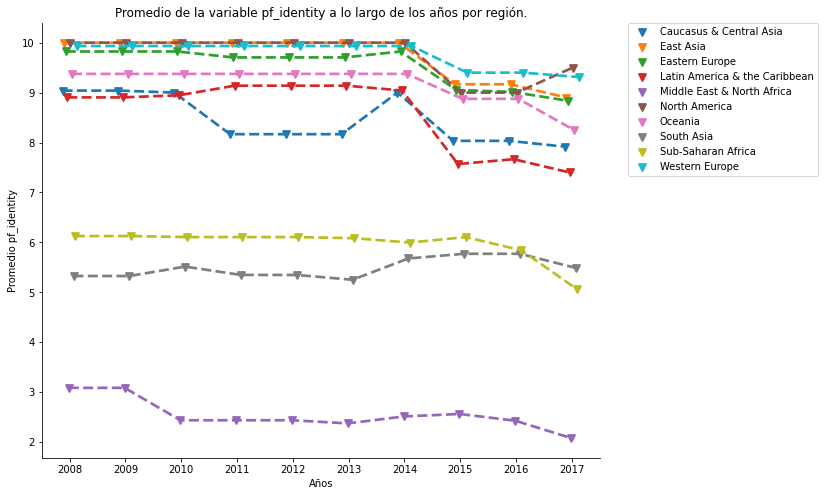

In [7]:
# Gráfico por región para pf_identity.

# Agrupamos las dos columnas por año y por región.
pf_identity_group_by_year_region = dataset[['year', 'region', 'pf_identity']].groupby(['region', 'year']).mean()
pf_identity_group_by_year_region = pf_identity_group_by_year_region.reset_index() # Ponemos al año como una columna

plt.figure(figsize=(10,8))
seaborn.pointplot(data=pf_identity_group_by_year_region,
                  x='year', y='pf_identity',
                  hue='region', dodge=True, ci=None,
                  markers='v', linestyles='--', errwidth=1, capsize=0.2)

plt.ylabel('Promedio pf_identity')
plt.xlabel('Años')
plt.title('Promedio de la variable pf_identity a lo largo de los años por región.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

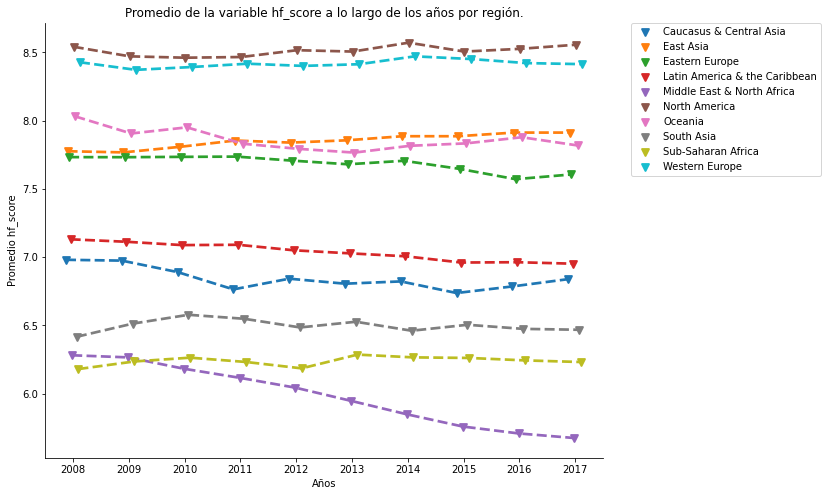

In [8]:
# Gráfico por región para hf_score.

# Agrupamos las dos columnas por año y por región.
hf_score_group_by_year_region = dataset[['year', 'region', 'hf_score']].groupby(['region', 'year']).mean()
hf_score_group_by_year_region = hf_score_group_by_year_region.reset_index() # Ponemos al año como una columna

plt.figure(figsize=(10,8))
seaborn.pointplot(data=hf_score_group_by_year_region,
                  x='year', y='hf_score',
                  hue='region', dodge=True, ci=None,
                  markers='v', linestyles='--', errwidth=1, capsize=0.2)

plt.ylabel('Promedio hf_score')
plt.xlabel('Años')
plt.title('Promedio de la variable hf_score a lo largo de los años por región.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

### 2.3 Tendencia de la variable pf_identity para Argentina y Venezuela

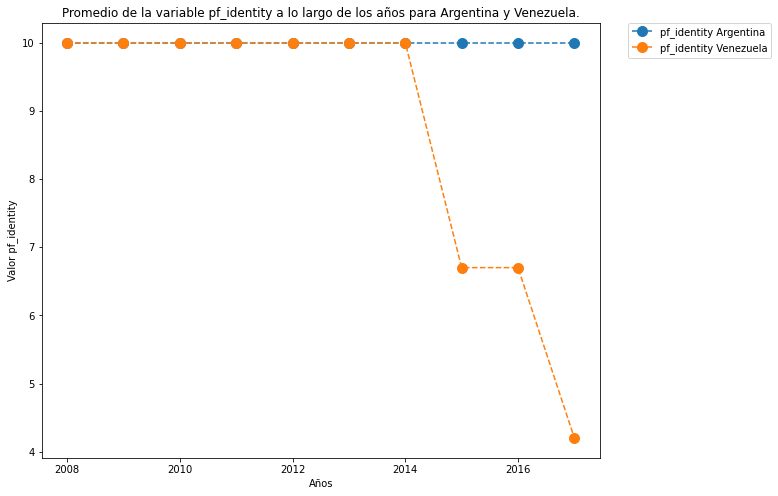

In [9]:
# Gráfico para Argentina para pf_identity a través del paso de los años.

# Agrupamos las dos columnas por año y Argentina.
arg_dataset = dataset[dataset.countries == 'Argentina']
venezuela_dataset = dataset[dataset.countries == 'Venezuela']


pf_identity_arg_group_by_year = arg_dataset[['year', 'pf_identity']].groupby('year').mean()
pf_identity_arg_group_by_year = pf_identity_arg_group_by_year.reset_index() # Ponemos al año como una columna

pf_identity_venezuela_group_by_year = venezuela_dataset[['year', 'pf_identity']].groupby('year').mean()
pf_identity_venezuela_group_by_year = pf_identity_venezuela_group_by_year.reset_index() # Ponemos al año como una columna


plt.figure(figsize=(10,8))
plt.plot(pf_identity_arg_group_by_year['year'], pf_identity_arg_group_by_year['pf_identity'], label='pf_identity Argentina',linestyle='--', marker='o', markersize=10)
plt.plot(pf_identity_venezuela_group_by_year['year'], pf_identity_venezuela_group_by_year['pf_identity'], label='pf_identity Venezuela',linestyle='--', marker='o', markersize=10)


plt.ylabel('Valor pf_identity')
plt.xlabel('Años')
plt.title('Promedio de la variable pf_identity a lo largo de los años para Argentina y Venezuela.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Para este punto seleccionamos el pais Argentina y podemos ver que la variable pf_identity siempre se ha mantenido en el valor 10 a través del transcurso de los años y lo comparamos con Venezuela que apartir del 2014 podemos observar que comienza a caer.


## 3. Distribuciones
1. Graficar en un mismo histograma la distribución de la variable pf_identity en global, y en Latinoamérica y el caribe. Repetir para la variable hf_score. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?

### 3.1 Histograma para pf_identity y hf_score global y en latinoamerica.

In [62]:
def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    # Here we can remove the outliers from both ends, or even add more restrictions.
    mask_salarios_outlier = (
        np.abs(interesting_col - interesting_col.mean()) <= (2.5 * interesting_col.std()))
    return dataset[mask_salarios_outlier]


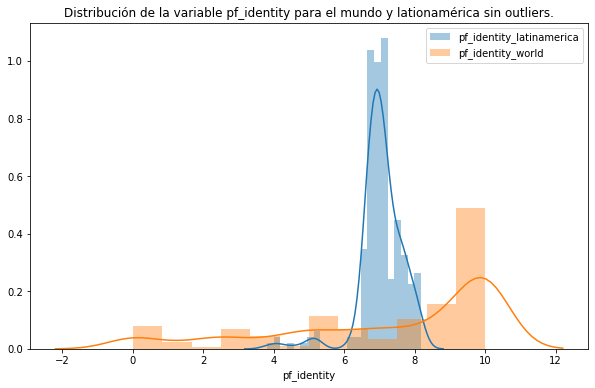

In [56]:
# Histograma para pf_identity global y en latinoamerica.
data = clean_outliers(dataset, "pf_identity")

pf_identity_latinamerica = data[(data.region == "Latin America & the Caribbean")]

plt.figure(figsize=(10,6))
plt.title('Distribución de la variable pf_identity para el mundo y lationamérica sin outliers.')
seaborn.distplot(pf_identity_latinamerica.hf_score, label='pf_identity_latinamerica')
seaborn.distplot(data.pf_identity, label='pf_identity_world')
plt.legend()

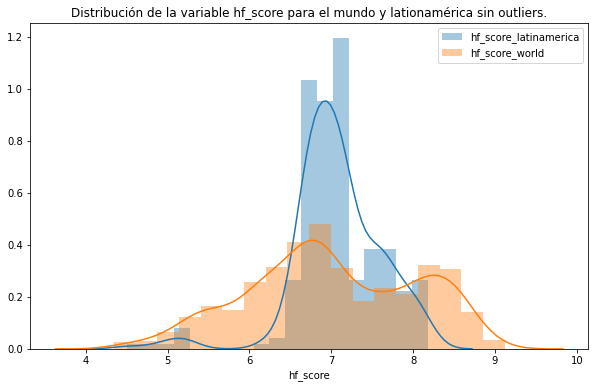

In [61]:
# Histograma para hf_score global y en latinoamerica.
data = clean_outliers(dataset, "hf_score")

hf_score_latinamerica = data[(data.region == "Latin America & the Caribbean")]

plt.figure(figsize=(10,6))
plt.title('Distribución de la variable hf_score para el mundo y lationamérica sin outliers.')
seaborn.distplot(hf_score_latinamerica.hf_score, label='hf_score_latinamerica')
seaborn.distplot(data.hf_score, label='hf_score_world')
plt.legend()

Para este ejercicio hemos removido los outliers. Tomamos como outliers a los valores que su diferencia con la media es mayor a 2.5 veces la desviación estandar.
Distribuciones para pf_identity:

Para pf_identity en latinoamercia podemos observar que se trata de una distribución normal y para el mundo es una distribución asimétrica sesgada a la derecha.

Distribuciones para hs_score:

Para hf_score en latinoamerica podemos observar que se trata de una distribución normal y para el mundo, creemos que también se trata de una distribución normal pero al tener una desviación estandar mayor, la curva es mas ancha y menos alta